In [1]:
# Importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
# Importing data

data_set = pd.read_csv('cleaned_data_ver_2.csv')

# Set index column

data_set.set_index('audio file',inplace=True)

data_set.head()

,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,loudness_sma3_amean,loudness_sma3_percentile50.0,loudness_sma3_meanRisingSlope,loudness_sma3_stddevRisingSlope,loudness_sma3_meanFallingSlope,loudness_sma3_stddevFallingSlope,spectralFlux_sma3_amean,...,slopeV500-1500_sma3nz_stddevNorm,spectralFluxV_sma3nz_amean,spectralFluxV_sma3nz_stddevNorm,spectralFluxUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,loudnessPeaksPerSec,MeanVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,equivalentSoundLevel_dBp,status
audio file,,,,,,,,,,,,,,,,,,,,,
adrso024,25.896833,7.935173,174.19131,0.549328,0.408067,7.424927,5.213052,7.055963,5.262211,0.508837,...,-0.567350,0.550346,1.225269,0.163655,21.262306,1.585821,0.733627,0.100488,-26.253954,ad
adrso025,31.419218,11.863705,276.19775,0.398178,0.238166,7.984493,9.199738,5.430153,5.992081,0.200731,...,-0.695343,0.327789,1.311078,0.069983,11.804278,0.774302,0.213387,0.221147,-32.320164,ad
adrso027,24.860962,11.135247,335.64285,0.460953,0.338455,8.206853,9.604611,5.465767,5.662509,0.207583,...,-0.940123,0.283992,1.236332,0.134296,14.144296,0.727537,0.099811,0.112874,-34.366104,ad
adrso028,27.134663,13.376965,248.23643,0.399583,0.185939,13.853819,12.248559,9.349718,8.396350,0.202821,...,-0.652363,0.235273,2.537468,0.118246,15.247038,0.482315,0.174490,0.069385,-28.948114,ad
adrso031,38.107906,22.327736,336.57800,0.358402,0.266022,5.982065,6.058165,5.824781,9.875219,0.149938,...,-0.909497,0.223593,1.312532,0.083634,14.497070,0.689995,0.171469,0.208814,-35.530070,ad


In [3]:
# Size of the data set
data_set.shape

(237, 43)

In [4]:
df = data_set

#### Train test split

In [5]:


X = df.iloc[:,:-1]
y = df['status']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X.copy(),y.copy(),
                                                       shuffle=True,
                                                       random_state=153,
                                                       stratify=y,
                                                       test_size=.2)


In [6]:
# Extra validation set for Logistic Regression cutoff search


X_train_v, X_val, y_train_v, y_val = train_test_split(X_train.copy(),y_train.copy(),
                                                       shuffle=True,
                                                       random_state=153,
                                                       stratify=y_train,
                                                       test_size=.2)




In [7]:
scaler = StandardScaler()

In [8]:
X_train_scaled = scaler.fit_transform(X_train)

In [9]:
X_test_scaled = scaler.transform(X_test)

In [10]:
X_train_v_scaled = scaler.transform(X_train_v)
X_val_scaled = scaler.transform(X_val)

#### Introducing cross-validation

In [11]:
kfold = KFold(n_splits = 5,
              shuffle = True,
              random_state = 582)

#### Model 1: Logistic Regression 

In [12]:
# Looking for cutoff for Logistic Regression

log_reg = LogisticRegression(penalty=None,max_iter = 500)
log_reg.fit(X_train_v_scaled,
            y_train_v)

y_prob = log_reg.predict_proba(X_train_v_scaled)[:,1]

cutoffs = np.arange(0,1.01,.01)

accs = []

y_train_v[y_train_v == 'ad'] = 1
y_train_v[y_train_v == 'cn'] = 0

y_val[y_val == 'ad'] = 1
y_val[y_val == 'cn'] = 0


for cutoff in cutoffs:
    y_test_pred = 1*(y_prob <= cutoff)
    accs.append(np.sum(y_test_pred == y_train_v)/len(y_train_v))


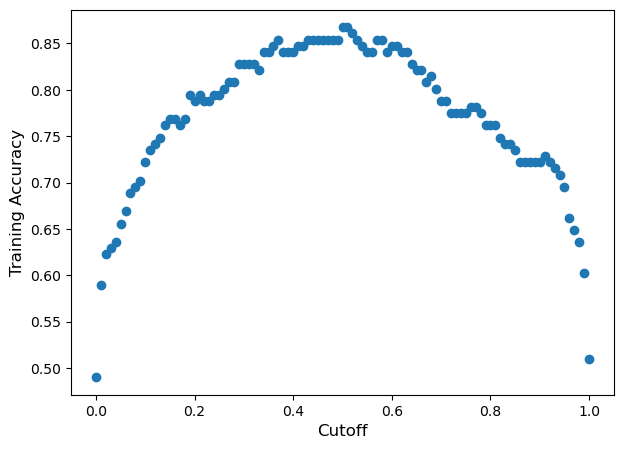

In [13]:
plt.figure(figsize=(7,5))

plt.scatter(cutoffs,accs)

plt.xlabel("Cutoff",fontsize=12)
plt.ylabel("Training Accuracy",fontsize=12)

plt.show()
    

In [14]:
cutoffs[np.argmax(accs)]

0.5

In [15]:
# Running cross-validation

j = 0
precision_mat = np.zeros((1,5))
recall_mat = np.zeros((1,5))
accuracy_mat = np.zeros((1,5))
cutoff = 0.5

for train_index, test_index in kfold.split(X_train_scaled, y_train):
    
    ### Training
    X_train_train = X_train_scaled[train_index,:]
    y_train_train = y_train[train_index]
    
    ### Holdout set
    X_holdout = X_train_scaled[test_index,:]
    y_holdout = y_train[test_index]

    log_reg = LogisticRegression(penalty=None,max_iter = 500)
    log_reg.fit(X_train_train,
            y_train_train)
    y_prob = log_reg.predict_proba(X_holdout)[:,1]
    
    y_preds = []
 
    for i in y_prob:
        if i <= cutoff:
            y_preds.append('ad')
        else:
            y_preds.append('cn')
         
    precision_mat[0,j] = precision_score(y_holdout, y_preds,average="binary", pos_label="ad")
    recall_mat[0,j] = recall_score(y_holdout, y_preds,average="binary", pos_label="ad")
    accuracy_mat[0,j] = accuracy_score(y_holdout, y_preds)
    
    
    j += 1
    
    
    
    



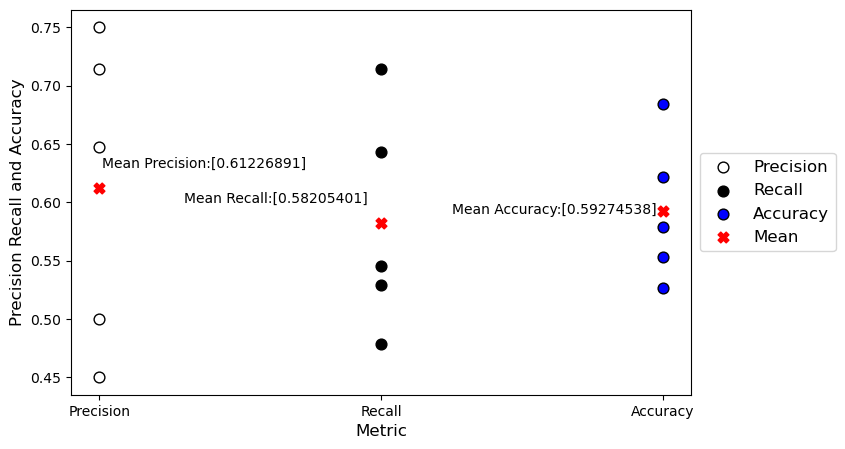

In [16]:
# Let's plot the metrices

plt.figure(figsize=(8,5))
plt.scatter(np.zeros(5), 
            precision_mat[0,:], 
            s=60, 
            c='white',
            edgecolor='black',
            label="Precision")



plt.scatter(np.ones(5), 
            recall_mat[0,:], 
            s=60, 
            c='black',
            edgecolor='black',label ="Recall")
plt.scatter(np.ones(5)*2, 
            accuracy_mat[0,:], 
            s=60, 
            c='blue',
            edgecolor='black',label ="Accuracy")

plt.scatter([0,1,2], 
            [np.mean(precision_mat, axis=1),np.mean(recall_mat, axis=1),np.mean(accuracy_mat, axis=1)], 
            s=60, 
            c='r',
            marker='X',
            label="Mean")
plt.annotate(f'Mean Precision:{np.mean(precision_mat, axis=1)}', xy=(0.01,0.63))
plt.annotate(f'Mean Recall:{np.mean(recall_mat, axis=1)}', xy=(0.3,0.60))
plt.annotate(f'Mean Accuracy:{np.mean(accuracy_mat, axis=1)}', xy=(1.25,0.59))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)

plt.xticks([0,1,2],["Precision", "Recall","Accuracy"], fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Metric", fontsize=12)
plt.ylabel("Precision Recall and Accuracy", fontsize=12)

plt.show()

The mean accurcay from cross-validation seems to be 62%. 

### Model 2: k-NN model

In [17]:
steps = [('knn', KNeighborsClassifier())]

pipeline = Pipeline(steps)

parameters = {"knn__n_neighbors": np.arange(1, 50)}


In [18]:
cv = GridSearchCV(pipeline, param_grid=parameters)
cv.fit(X_train_scaled, y_train)


GridSearchCV(estimator=Pipeline(steps=[('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [19]:
print(cv.best_score_)
print(cv.best_params_)

0.6984352773826458
{'knn__n_neighbors': 14}


#### Let's use cross validation

In [20]:
j = 0
precision_knn_mat = np.zeros((1,5))
recall_knn_mat = np.zeros((1,5))
accuracy_knn_mat = np.zeros((1,5))

for train_index, test_index in kfold.split(X_train_scaled, y_train):
    
    ### Training
    X_train_train = X_train_scaled[train_index,:]
    y_train_train = y_train[train_index]
    
    ### Holdout set
    X_holdout = X_train_scaled[test_index,:]
    y_holdout = y_train[test_index]
    


    knn_class = KNeighborsClassifier(n_neighbors=14)
    knn_class.fit(X_train_train,
            y_train_train)
    
    y_preds = knn_class.predict(X_holdout)

    precision_knn_mat[0,j] = precision_score(y_holdout, y_preds,average="binary", pos_label="ad")
    recall_knn_mat[0,j] = recall_score(y_holdout, y_preds,average="binary", pos_label="ad")
    accuracy_knn_mat[0,j] = accuracy_score(y_holdout, y_preds)
    
    
    
    j += 1
    
    

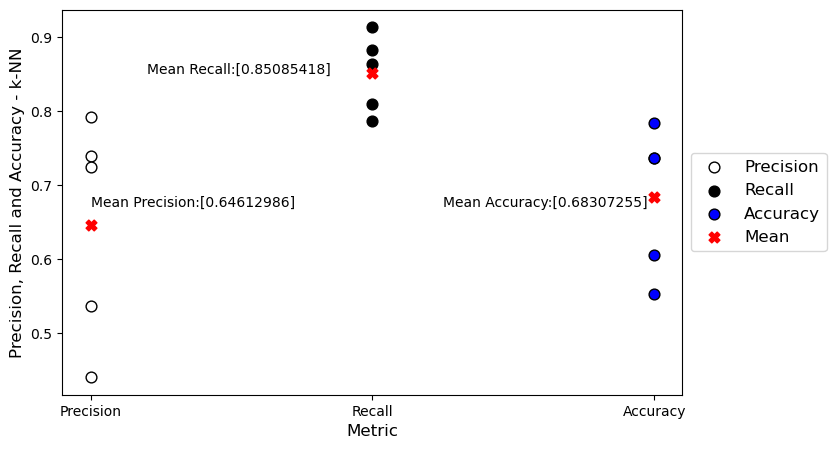

In [21]:
plt.figure(figsize=(8,5))
plt.scatter(np.zeros(5), 
            precision_knn_mat[0,:], 
            s=60, 
            c='white',
            edgecolor='black',
            label="Precision")
plt.scatter(np.ones(5), 
            recall_knn_mat[0,:], 
            s=60, 
            c='black',
            edgecolor='black',label ="Recall")

plt.scatter(np.ones(5)*2, 
            accuracy_knn_mat[0,:], 
            s=60, 
            c='blue',
            edgecolor='black',label ="Accuracy")

plt.scatter([0,1,2], 
            [np.mean(precision_knn_mat, axis=1),np.mean(recall_knn_mat, axis=1),np.mean(accuracy_knn_mat, axis=1)], 
            s=60, 
            c='r',
            marker='X',
            label="Mean")

plt.annotate(f'Mean Precision:{np.mean(precision_knn_mat, axis=1)}', xy=(0,0.67))
plt.annotate(f'Mean Recall:{np.mean(recall_knn_mat, axis=1)}', xy=(0.2,0.85))
plt.annotate(f'Mean Accuracy:{np.mean(accuracy_knn_mat, axis=1)}', xy=(1.25,0.67))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)

plt.xticks([0,1,2],["Precision", "Recall","Accuracy"], fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Metric", fontsize=12)
plt.ylabel("Precision, Recall and Accuracy - k-NN", fontsize=12)

plt.show()

Mean accuracy is 68%

### Model 3: SVM modelling

In [22]:
steps = [('svm', SVC())]

pipeline = Pipeline(steps)

parameters = {"svm__C": np.arange(1, 15),"svm__gamma": np.arange(0.001,1,0.001),"svm__kernel": ['rbf']}

In [23]:
cv = GridSearchCV(pipeline, param_grid=parameters)
cv.fit(X_train_scaled, y_train)


GridSearchCV(estimator=Pipeline(steps=[('svm', SVC())]),
             param_grid={'svm__C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'svm__gamma': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
       0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036...
       0.937, 0.938, 0.939, 0.94 , 0.941, 0.942, 0.943, 0.944, 0.945,
       0.946, 0.947, 0.948, 0.949, 0.95 , 0.951, 0.952, 0.953, 0.954,
       0.955, 0.956, 0.957, 0.958, 0.959, 0.96 , 0.961, 0.962, 0.963,
       0.964, 0.965, 0.966, 0.967, 0.968, 0.969, 0.97 , 0.971, 0.972,
       0.973, 0.974, 0.975, 0.976, 0.977, 0.978, 0.979, 0.98 , 0.981,
       0.982, 0.983, 0.984, 0.985, 0.986, 0.987, 0.988, 0.989, 0.99 ,
       0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999]),
                         'svm__kernel': ['rbf']})

In [24]:
print(cv.best_score_)
print(cv.best_params_)

0.6822190611664296
{'svm__C': 8, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}


#### Cross Validation first

In [25]:
j = 0
precision_svm_mat = np.zeros((1,5))
recall_svm_mat = np.zeros((1,5))
accuracy_svm_mat = np.zeros((1,5))

for train_index, test_index in kfold.split(X_train_scaled, y_train):
    
    ### Training
    X_train_train = X_train_scaled[train_index,:]
    y_train_train = y_train[train_index]
    
    ### Holdout set
    X_holdout = X_train_scaled[test_index,:]
    y_holdout = y_train[test_index]
       
    
    svc_rbf = SVC(kernel='rbf',C=8,gamma = 0.001)
    
    svc_rbf.fit(X_train_train,
            y_train_train)
    
    y_preds = svc_rbf.predict(X_holdout)
   
    
    precision_svm_mat[0,j] = precision_score(y_holdout, y_preds,average="binary", pos_label="ad")
    recall_svm_mat[0,j] = recall_score(y_holdout, y_preds,average="binary", pos_label="ad")
    accuracy_svm_mat[0,j] = accuracy_score(y_holdout, y_preds)
    
    
    
    j += 1
    
    

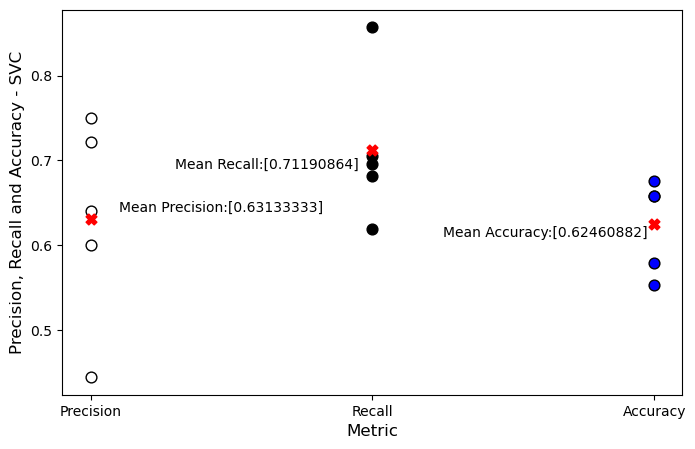

In [26]:
plt.figure(figsize=(8,5))
plt.scatter(np.zeros(5), 
            precision_svm_mat[0,:], 
            s=60, 
            c='white',
            edgecolor='black',
            label="Precision")
plt.scatter(np.ones(5), 
            recall_svm_mat[0,:], 
            s=60, 
            c='black',
            edgecolor='black',label ="Recall")

plt.scatter(np.ones(5)*2, 
            accuracy_svm_mat[0,:], 
            s=60, 
            c='blue',
            edgecolor='black',label ="Accuracy")

plt.scatter([0,1,2], 
            [np.mean(precision_svm_mat, axis=1),np.mean(recall_svm_mat, axis=1),np.mean(accuracy_svm_mat, axis=1)], 
            s=60, 
            c='r',
            marker='X',
            label="Mean")

plt.annotate(f'Mean Precision:{np.mean(precision_svm_mat, axis=1)}', xy=(0.1,0.64))
plt.annotate(f'Mean Recall:{np.mean(recall_svm_mat, axis=1)}', xy=(0.3,0.69))
plt.annotate(f'Mean Accuracy:{np.mean(accuracy_svm_mat, axis=1)}', xy=(1.25,0.61))

plt.xticks([0,1,2],["Precision", "Recall","Accuracy"], fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Metric", fontsize=12)
plt.ylabel("Precision, Recall and Accuracy - SVC", fontsize=12)

plt.show()

We can see mean accuracy is 63% and also recall and precision metrics are slightly higher than other models. Therefore, let's choose SVM as the final baseline model with C=8, gamma = 0.001 and RBF kernel. 

#### Let's use the test set with DVM

In [27]:
svc_class = SVC(kernel='rbf',C=8,gamma = 0.001)
svc_class.fit(X_train_scaled,
            y_train)
    
y_preds = svc_class.predict(X_test_scaled)

In [28]:
precision = precision_score(y_test, y_preds,average="binary", pos_label="ad")
recall = recall_score(y_test, y_preds,average="binary", pos_label="ad")
accuracy = accuracy_score(y_test, y_preds)
print('Accuracy',accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy 0.625
Precision: 0.6842105263157895
Recall: 0.52


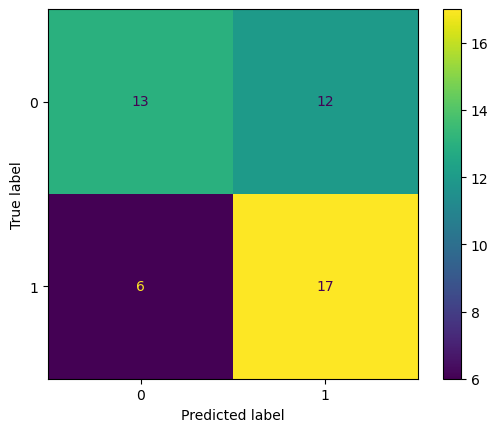

In [29]:
cm_new = confusion_matrix(y_test, y_preds)

ConfusionMatrixDisplay(confusion_matrix=cm_new).plot();